In [31]:
import pandas as pd
df = pd.read_csv('qm9_dataset.csv')
df.head()

,index,smiles,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
0,3895,O=C1C=CON=N1,3.3067,46.55,-0.2630,-0.0607,0.2023,965.3567,0.049003,-375.430225,-375.421157,-375.420213,-375.469933,24.943
1,3896,O=C1C=NOC=N1,2.4177,46.66,-0.2701,-0.0861,0.1840,567.5171,0.055941,-375.359188,-375.354066,-375.353122,-375.388412,17.987
2,3897,O=C1C=NON=C1,0.2386,48.24,-0.2681,-0.1008,0.1674,577.0287,0.054950,-375.307060,-375.301908,-375.300964,-375.336105,18.514
3,3898,O=C1C=NON=N1,1.5473,45.28,-0.2714,-0.1200,0.1514,556.6358,0.041330,-391.337881,-391.332272,-391.331328,-391.367925,19.012
4,3899,O=C1N=CON=N1,1.7309,41.79,-0.2961,-0.0570,0.2391,913.3757,0.038631,-391.518453,-391.509552,-391.508608,-391.558096,23.419


In [32]:
smiles_list = df['smiles'].tolist()

In [ ]:
from rdkit import RDConfig, Chem
import os
import pandas as pd
from collections import Counter

def extract_functional_group_counts(smiles):
    """
    Detects and counts functional groups in a molecule based on names
    from FunctionalGroups.txt.
    """
    fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
    fparams = FragmentCatalog.FragCatParams(1, 6, fName)
    fcat = FragmentCatalog.FragCatalog(fparams)
    fcgen = FragmentCatalog.FragCatGenerator()

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series({'Molecule': smiles})

    num_matched_frags = fcgen.AddFragsFromMol(mol, fcat)
    functional_group_counts = {}

    if num_matched_frags > 0:
        for i in range(num_matched_frags):
            func_group_ids = fcat.GetEntryFuncGroupIds(i)
            if func_group_ids:
                func_group_id = func_group_ids[0]
                frag = fparams.GetFuncGroup(func_group_id)
                try:
                    name = frag.GetProp('_Name')
                    functional_group_counts[name] = functional_group_counts.get(name, 0) + 1
                except AttributeError:
                    # Handle cases where _Name property might be missing
                    description = fcat.GetEntryDescription(i)
                    functional_group_counts[description] = functional_group_counts.get(description, 0) + 1

    functional_group_counts['Molecule'] = smiles
    atom_types = Counter([atom.GetSymbol() for atom in mol.GetAtoms()])
    functional_group_counts.update(atom_types)  # Add atom counts to the dictionary
    return pd.Series(functional_group_counts)

# Example usage with the corrected SMILES
#smiles_list = ['O=C1C=CON=N1', 'CCO', 'CC(=O)O', 'c1ccccc1[N+](=O)[O-]', 'O=C(O)C(=O)O']
all_molecule_counts = []

for smiles in smiles_list:
    counts = extract_functional_group_counts(smiles)
    all_molecule_counts.append(counts)

final_df = pd.DataFrame(all_molecule_counts).fillna(0).set_index('Molecule')

print(final_df)


                =O    O  C    N   -O   =N  =N-O  -C(=O)H  -C#CH  -C#N  ...  \
Molecule                                                               ...   
O=C1C=CON=N1  21.0  2.0  3  2.0  0.0  0.0   0.0      0.0    0.0   0.0  ...   
O=C1C=NOC=N1  21.0  2.0  3  2.0  0.0  0.0   0.0      0.0    0.0   0.0  ...   
O=C1C=NON=C1  12.0  2.0  3  2.0  0.0  0.0   0.0      0.0    0.0   0.0  ...   
O=C1C=NON=N1  21.0  2.0  2  3.0  0.0  0.0   0.0      0.0    0.0   0.0  ...   
O=C1N=CON=N1  20.0  2.0  2  3.0  0.0  0.0   0.0      0.0    0.0   0.0  ...   
...            ...  ... ..  ...  ...  ...   ...      ...    ...   ...  ...   
N#CC1=NCCCO1   0.0  1.0  5  2.0  0.0  0.0   0.0      0.0    0.0  21.0  ...   
C#CC1CC=CCO1   0.0  1.0  7  0.0  0.0  0.0   0.0      0.0   21.0   0.0  ...   
C#CC1CCC=CC1   0.0  0.0  8  0.0  0.0  0.0   0.0      0.0   18.0   0.0  ...   
C#CC1CCN=CO1   0.0  1.0  6  1.0  0.0  0.0   0.0      0.0   21.0   0.0  ...   
C#CC1COC=NC1   0.0  1.0  6  1.0  0.0  0.0   0.0      0.0   20.0 

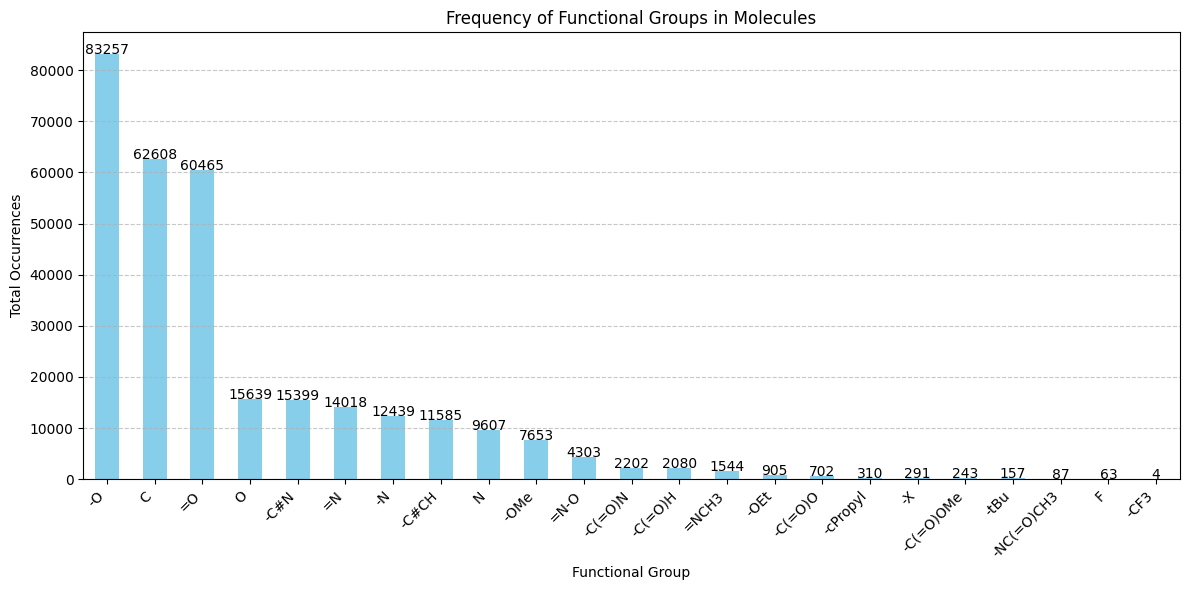

In [34]:
import matplotlib.pyplot as plt

# Sum the occurrences of each functional group across all molecules
func_group_totals = final_df.sum().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
func_group_totals.plot(kind='bar', color='skyblue')
plt.title('Frequency of Functional Groups in Molecules')
plt.xlabel('Functional Group')
plt.ylabel('Total Occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optionally, add value labels on top of each bar
for i, v in enumerate(func_group_totals):
    plt.text(i, v + 0.1, f'{int(v)}', ha='center')

plt.show()


In [38]:
# Extract energy values (U0, U, H, G, Cv) from df
energy_values = df[['smiles', 'U0', 'U', 'H', 'G', 'Cv']].set_index('smiles')

# Update the final_df with these energy values
final_df[['U0', 'U', 'H', 'G', 'Cv']] = energy_values.loc[final_df.index]

# Display the first few rows to confirm the update
final_df.head()
# Save the final DataFrame to a CSV file
final_df.to_csv('functional_group_counts_with_Thermodynamics.csv', index=True)

In [39]:
final_df.head()


,=O,O,C,N,-O,=N,=N-O,-C(=O)H,-C#CH,-C#N,...,-cPropyl,-tBu,-C(=O)OMe,-C(=O)O,-NC(=O)CH3,U0,U,H,G,Cv
Molecule,,,,,,,,,,,,,,,,,,,,,
O=C1C=CON=N1,21.0,2.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-375.430225,-375.421157,-375.420213,-375.469933,24.943
O=C1C=NOC=N1,21.0,2.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-375.359188,-375.354066,-375.353122,-375.388412,17.987
O=C1C=NON=C1,12.0,2.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-375.307060,-375.301908,-375.300964,-375.336105,18.514
O=C1C=NON=N1,21.0,2.0,2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-391.337881,-391.332272,-391.331328,-391.367925,19.012
O=C1N=CON=N1,20.0,2.0,2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-391.518453,-391.509552,-391.508608,-391.558096,23.419


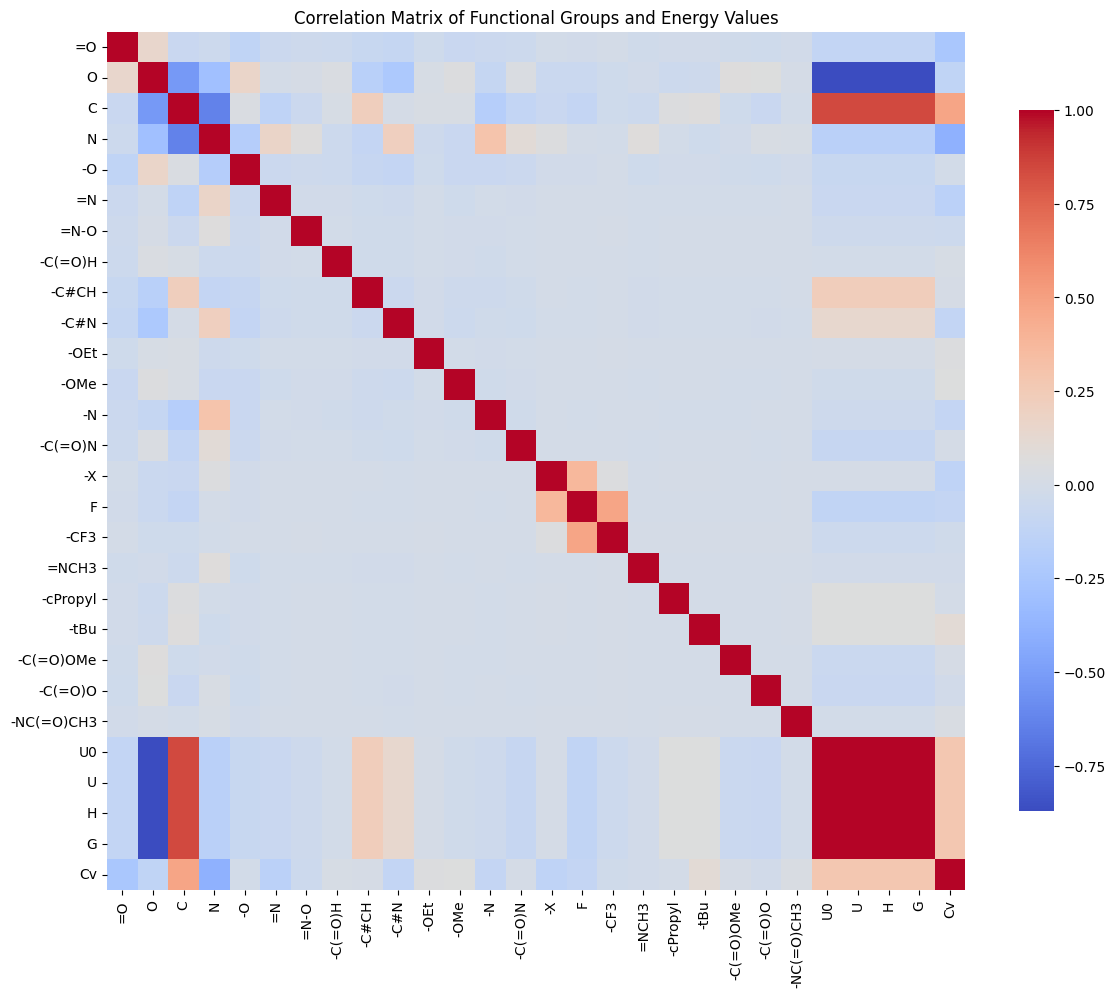

In [41]:
# Correlation matrix for functional groups and energy values
correlation_matrix = final_df.corr()

# Plotting the correlation matrix
import seaborn as sns
plt.figure(figsize=(12, 10))
# Using a heatmap to visualize the correlation matrix without data labels
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Functional Groups and Energy Values')
plt.tight_layout()
plt.show()